## Pareto Front

В повседневной жизни мы регулярно оказываемся в ситуациях, когда хочется и рыбку съесть, и косточкой не подавиться:
- Не прогадать по цене/качеству, переключаясь в маркетплейсе между "подешевле" и "много звёздочек".
- Вложить деньги ~~в какую-нибудь пирамиду~~ с оптимальным соотношением риск/доходность.

На языке науки это называется [multi-objective optimization](https://en.wikipedia.org/wiki/Multi-objective_optimization) -  многофакторная/многокритериальная оптимизация.

<!--more-->

Рассмотрим примерчик. В результате неких исследований мы собрали такой набор пар:

In [1]:
data = [
    (24.7, 0.54), (36.1, 0.47), (55.3, 0.69), (52.2, 0.56),
    (19.4, 0.51), (66.6, 0.69), (31.9, 0.52), (25.8, 0.73),
    (22.1, 0.53), (37.3, 0.50), (34.8, 0.55), (57.2, 0.68),
    (49.4, 0.54), (33.2, 0.48), (17.7, 0.57), (16.2, 0.51),
    (42.8, 0.70), (14.4, 0.55), (40.0, 0.70), (21.0, 0.57),
    (38.6, 0.70), (58.6, 0.68), (29.5, 0.56), (45.2, 0.70),
    (44.1, 0.68), (41.2, 0.69), (50.6, 0.68), (47.5, 0.50),
    (27.7, 0.50), (23.3, 0.56), (30.8, 0.53), (68.1, 0.69),
]

Пусть это будут финансовые показатели. Первая ось - условная доходность. Вторая - условный риск. Нас интересует максимум по первой оси и минимум по второй.

Чтобы не путаться в максимумах и минимумах, можно развернуть вторую ось:

In [2]:
data = [(i[0], -i[1]) for i in data]

Теперь нас интересует максимум по обеим осям. Графически его следует искать где-то на северо-востоке:

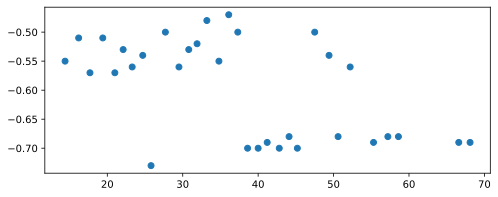

In [3]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.figure(figsize=[8, 3])
plt.scatter(*zip(*data))
plt.show()

Но верхний правый угол выглядит пустовато. Это значит, что нет явного лидера по обеим осям. Как быть?

### Ингредиент 1: non-dominated compare

Нам понадобится вот такая операция:

In [4]:
def who_dominates(vec1, vec2):
    better_count = 0
    worse_count = 0

    for i in range(0, len(vec1)):
        val1, val2 = vec1[i], vec2[i]

        if val1 == val2:
            continue

        if val2 > val1:
            better_count += 1
        else:
            worse_count += 1

        if better_count > 0 and worse_count > 0:
            return 0

    if better_count > 0 and worse_count == 0:
        return 1

    if worse_count > 0 and better_count == 0:
        return -1

    return 0

На вход даём два вектора. Сравниваем их по компонентам. Считаем преимущества `better_count` и отставания `worse_count`.

- Если оба счётчика превысили единицу или остались по нулям, то такая ситуация называется "non-domination", "не-преобладание". Возвращаем 0 в таких случаях.
- Если есть только преимущества, возвращаем +1
- Если только отставания, то -1.

Примеры:

In [5]:
# равенство
who_dominates((0, 0), (0, 0))

0

In [6]:
# противоречие
who_dominates((3, 0), (0, 3))

0

In [7]:
# преимущество по второй оси
who_dominates((0, 0), (0, 3))

1

In [8]:
# отставание по второй оси
who_dominates((0, 0), (0, -3))

-1

### Ингредиент 2: собственно Pareto front

Станем складывать вектора в список. Каждый добавляемый вектор будем сравнивать с ранее накопленными через `who_dominates`. Один из векторов отбрасываем, если результат сравнения отличен от нуля.

In [9]:
front = []
pending_front = []


def front_push(candidate):
    global front, pending_front

    will_add = True

    for existing in front:
        domination_result = who_dominates(existing, candidate)

        if domination_result == 0:
            pending_front.append(existing)

        elif domination_result < 0:
            pending_front.append(existing)
            will_add = False

    if will_add:
        pending_front.append(candidate)

    front, pending_front = pending_front, front
    pending_front.clear()

Таким образом, по ходу заполнения списка аутсайдеры вытесняются, а лидеры накапливаются и формируют так называемый фронтир или фронт, [оптимальный по Парето](https://ru.wikipedia.org/wiki/Эффективность_по_Парето).

Я написал алгоритм на двух чередующихся списках: на каждой итерации вектора-лидеры перекладываются из одного списка в другой, а сами списки меняются местами.

Если этой дискриминационной процедуре подвергнуть наши данные

In [10]:
for i in data:
    front_push(i)

то уцелеют 6 пар:

In [11]:
front.sort()
front

[(36.1, -0.47),
 (47.5, -0.5),
 (49.4, -0.54),
 (52.2, -0.56),
 (58.6, -0.68),
 (68.1, -0.69)]

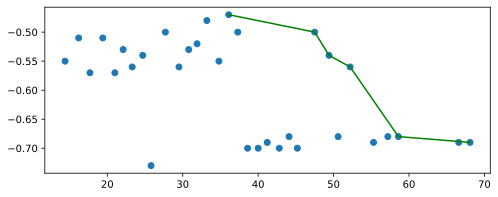

In [12]:
plt.figure(figsize=[8, 3])
plt.scatter(*zip(*data))
plt.plot(*zip(*front), color='g')
plt.show()

Именно на этих 6 точках следует сосредоточить внимание. Дальнейший отсев альтернатив - творческий процесс поиска золотой середины.

Заполнение Pareto-фронтов используется в составе более хитрых алгоритмов оптимизации, таких как [NSGA-II](https://youtu.be/SL-u_7hIqjA).